In [ ]:
# 1. System Setup, Warnings, Reproducibility
import warnings      # Hide warnings during training
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)



import random
import numpy as np    # Numerical operations
import pandas as pd   # Data handling (DataFrames)
import torch          # Required for TabNet
import tensorflow as tf  # Used for neural network models (MLP, CNN)

# Fix randomness for reproducible results
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

import joblib  # Saving/loading scalers and models
# 2. Visualization
import matplotlib.pyplot as plt     # Basic plotting
import seaborn as sns               # Statistical visualization
import plotly.express as px         # Interactive plots
# 3. Preprocessing & Splitting
from sklearn.model_selection import train_test_split, StratifiedKFold  # Splitting + CV
from sklearn.preprocessing import StandardScaler                        # Feature scaling
from sklearn.utils.class_weight import compute_class_weight            # Handle class imbalance
# 4. Machine Learning Models
from sklearn.linear_model import LogisticRegression         # Baseline model
from sklearn.ensemble import RandomForestClassifier         # Traditional ML benchmark
from xgboost import XGBClassifier                           # Gradient boosting model
from lightgbm import LGBMClassifier                         # Fast boosting model
from pytorch_tabnet.tab_model import TabNetClassifier       # Main model (TabNet)
# 5. Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    f1_score,
    balanced_accuracy_score
)


In [54]:
dataset_link = r'C:\Users\ATHEER\Downloads\PRO1\Students Performance Dataset.csv'
df = pd.read_csv(dataset_link)
df

,Student_ID,First_Name,Last_Name,Email,Gender,Age,Department,Attendance (%),Midterm_Score,Final_Score,...,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,S1000,Omar,Williams,student0@university.com,Female,22,Mathematics,97.36,40.61,59.61,...,62.84,59.8865,F,10.3,Yes,No,Master's,Medium,1,5.9
1,S1001,Maria,Brown,student1@university.com,Male,18,Business,97.71,57.27,74.00,...,98.23,81.9170,B,27.1,No,No,High School,Low,4,4.3
2,S1002,Ahmed,Jones,student2@university.com,Male,24,Engineering,99.52,41.84,63.85,...,91.22,67.7170,D,12.4,Yes,No,High School,Low,9,6.1
3,S1003,Omar,Williams,student3@university.com,Female,24,Engineering,90.38,45.65,44.44,...,55.48,51.6535,F,25.5,No,Yes,High School,Low,8,4.9
4,S1004,John,Smith,student4@university.com,Female,23,CS,59.41,53.13,61.77,...,87.43,71.4030,C,13.3,Yes,No,Master's,Medium,6,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,S5995,Ahmed,Jones,student4995@university.com,Male,19,CS,96.09,45.86,45.63,...,51.66,53.5470,F,7.8,No,No,Master's,Medium,10,4.5
4996,S5996,Emma,Brown,student4996@university.com,Male,19,Mathematics,96.30,78.67,47.42,...,52.33,59.0240,F,24.2,No,Yes,NaN,Medium,4,7.2
4997,S5997,John,Brown,student4997@university.com,Female,24,CS,89.94,50.84,65.83,...,97.89,74.7560,C,7.6,No,Yes,NaN,High,5,6.6
4998,S5998,Sara,Davis,student4998@university.com,Male,23,Engineering,99.09,55.44,57.45,...,84.74,68.6585,D,14.5,Yes,No,PhD,Medium,10,5.9


Data Preprocessing

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Student_ID                  5000 non-null   object 
 1   First_Name                  5000 non-null   object 
 2   Last_Name                   5000 non-null   object 
 3   Email                       5000 non-null   object 
 4   Gender                      5000 non-null   object 
 5   Age                         5000 non-null   int64  
 6   Department                  5000 non-null   object 
 7   Attendance (%)              5000 non-null   float64
 8   Midterm_Score               5000 non-null   float64
 9   Final_Score                 5000 non-null   float64
 10  Assignments_Avg             5000 non-null   float64
 11  Quizzes_Avg                 5000 non-null   float64
 12  Participation_Score         5000 non-null   float64
 13  Projects_Score              5000 

In [56]:
df.describe()

,Age,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Total_Score,Study_Hours_per_Week,Stress_Level (1-10),Sleep_Hours_per_Night
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000
mean,21.048400,75.356076,70.701924,69.546552,74.956320,74.836214,49.963720,74.78305,71.652097,17.521140,5.507200,6.514420
std,1.989786,14.392716,17.436325,17.108996,14.404287,14.423848,28.989785,14.54243,7.230097,7.193035,2.886662,1.446155
min,18.000000,50.010000,40.000000,40.010000,50.000000,50.000000,0.000000,50.00000,50.602000,5.000000,1.000000,4.000000
25%,19.000000,62.945000,55.707500,54.697500,62.340000,62.357500,25.075000,61.97000,66.533875,11.500000,3.000000,5.300000
50%,21.000000,75.670000,70.860000,69.485000,75.090000,74.905000,49.600000,74.54000,71.696250,17.400000,6.000000,6.500000
75%,23.000000,87.862500,85.760000,83.922500,87.352500,87.292500,75.500000,87.63000,76.711625,23.700000,8.000000,7.800000
max,24.000000,100.000000,99.990000,99.980000,99.990000,99.990000,100.000000,100.00000,95.091500,30.000000,10.000000,9.000000


In [57]:
df.isnull().sum()

Student_ID                       0
First_Name                       0
Last_Name                        0
Email                            0
Gender                           0
Age                              0
Department                       0
Attendance (%)                   0
Midterm_Score                    0
Final_Score                      0
Assignments_Avg                  0
Quizzes_Avg                      0
Participation_Score              0
Projects_Score                   0
Total_Score                      0
Grade                            0
Study_Hours_per_Week             0
Extracurricular_Activities       0
Internet_Access_at_Home          0
Parent_Education_Level        1025
Family_Income_Level              0
Stress_Level (1-10)              0
Sleep_Hours_per_Night            0
dtype: int64

In [58]:
df.duplicated().sum()

0

In [59]:
for col in [
    "Gender", "Age", "Department","Grade",
    "Extracurricular_Activities", "Internet_Access_at_Home",
    "Parent_Education_Level", "Family_Income_Level", "Stress_Level (1-10)"]:
    print(f"Unique values for {col}:", df[col].unique())

Unique values for Gender: ['Female' 'Male']
Unique values for Age: [22 18 24 23 21 19 20]
Unique values for Department: ['Mathematics' 'Business' 'Engineering' 'CS']
Unique values for Grade: ['F' 'B' 'D' 'C' 'A']
Unique values for Extracurricular_Activities: ['Yes' 'No']
Unique values for Internet_Access_at_Home: ['No' 'Yes']
Unique values for Parent_Education_Level: ["Master's" 'High School' nan "Bachelor's" 'PhD']
Unique values for Family_Income_Level: ['Medium' 'Low' 'High']
Unique values for Stress_Level (1-10): [ 1  4  9  8  6  2  5  7 10  3]


In [60]:
df.groupby("Grade")["Total_Score"].describe()

,count,mean,std,min,25%,50%,75%,max
Grade,,,,,,,,
A,16.0,91.277375,1.373792,90.0900,90.351125,90.80425,91.748000,95.0915
B,638.0,83.127444,2.362977,80.0020,81.127125,82.64775,84.633375,89.9665
C,2307.0,74.515495,2.800034,70.0005,72.107250,74.37450,76.770750,79.9990
D,1760.0,65.795618,2.770553,60.0140,63.694500,66.16800,68.113875,69.9990
F,279.0,57.552701,2.105641,50.6020,56.411750,58.22600,59.320000,59.9925


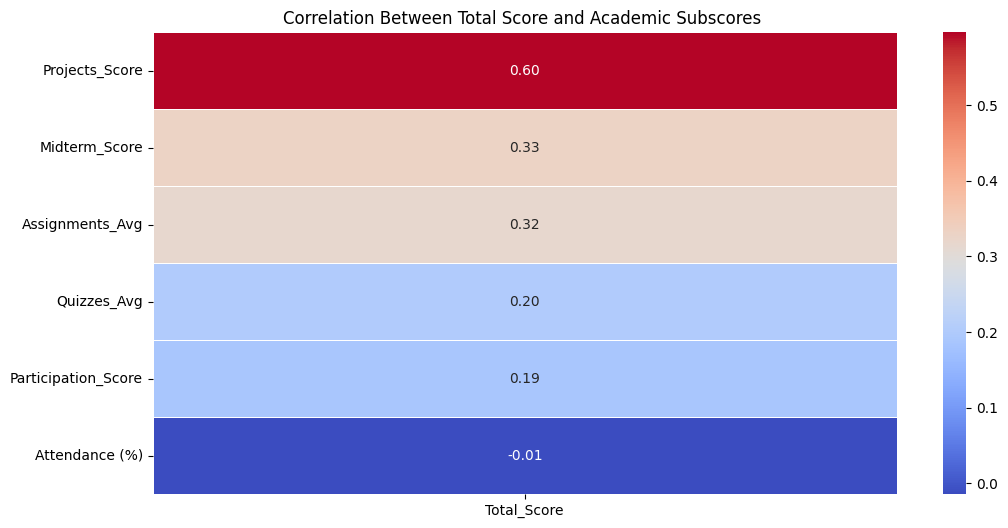

In [61]:
from typing import List
from pandas import DataFrame

def numerical_to_numerical_correlation(df: DataFrame, features: List[str], target_column: str, features_name: str = "Selected Features") -> None:
    numeric_df = df.select_dtypes(include=['number'])
    features = [feat for feat in features if feat != target_column]
    plt.figure(figsize=(12, 6))
    
    sns.heatmap(
        numeric_df.corr().loc[features, [target_column]].sort_values(by=target_column, ascending=False),
        annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5
    )
    
    plt.title(f"Correlation Between {target_column} and {features_name}".replace("_", " "))
    plt.savefig(plt.gca().get_title().replace(" ", "_") + ".pdf")
    plt.show()
academic_subscores = [
    'Attendance (%)', 'Participation_Score', 'Quizzes_Avg',
    'Assignments_Avg', 'Midterm_Score',
    'Projects_Score'
]
numerical_to_numerical_correlation(df, academic_subscores, 'Total_Score',  'Academic Subscores ')

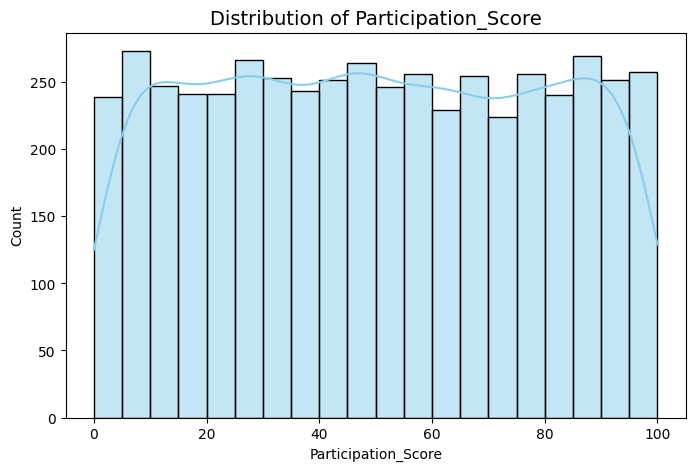

In [62]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Participation_Score'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Participation_Score', fontsize=14)
plt.xlabel('Participation_Score')
plt.ylabel('Count')
plt.show()

Cleaning  Data


In [63]:
#Cleaning up Data Fill missing data¶
df['Parent_Education_Level']=df['Parent_Education_Level'].fillna('Unknown')

In [64]:
#Fix Total_Score¶
# Updated score weights
score_weights = {
    "Midterm_Score": 0.15,
    "Final_Score": 0.25,
    "Assignments_Avg": 0.15,
    "Quizzes_Avg": 0.10,
    "Participation_Score": 0.05,
    "Projects_Score": 0.30,
}

df['Total_Score'] = (
    df["Midterm_Score"] * score_weights["Midterm_Score"] +
    df["Final_Score"] * score_weights["Final_Score"] +
    df["Assignments_Avg"] * score_weights["Assignments_Avg"] +
    df["Quizzes_Avg"] * score_weights["Quizzes_Avg"] +
    (df["Participation_Score"] *score_weights["Participation_Score"]) +  # scaled from [0–10] to [0–100]
    df["Projects_Score"] * score_weights["Projects_Score"]
).clip(0, 100)


In [65]:
#Finally, remove all unnecessary columns
def safe_drop(df: DataFrame, column) -> DataFrame:
    if column in df.columns:
        return df.drop(columns=column)
    return df


In [66]:
useless_columns = ['Student_ID', 'First_Name', 'Last_Name', 'Email',"Grade",'Final_Score',"Total_Score"]
for col in useless_columns:
    df = safe_drop(df, col)

    "Midterm_Score": 0.15,
    "Final_Score": 0.25,
    "Assignments_Avg": 0.15,
    "Quizzes_Avg": 0.10,
    "Participation_Score": 0.05,
    "Projects_Score": 0.30,                           
    دي المعلومه من مصدر البينات 

    يعني اعمال السنه من 75 ونصها 37.5

In [67]:
# Fix Total_Score (without Final_Score)

# Updated normalized weights after removing Final_Score
score_weights = {
    "Midterm_Score": 0.20,         # 20%
    "Assignments_Avg": 0.20,       # 20%
    "Quizzes_Avg": 0.1333,         # 13.3%
    "Participation_Score": 0.0667, # 6.7%
    "Projects_Score": 0.40         # 40%
}

# Compute new Total_Score (out of 100)
df['Total_Score'] = (
    df["Midterm_Score"] * score_weights["Midterm_Score"] +
    df["Assignments_Avg"] * score_weights["Assignments_Avg"] +
    df["Quizzes_Avg"] * score_weights["Quizzes_Avg"] +
    (df["Participation_Score"] ) * score_weights["Participation_Score"] +  # scaled 0–10 → 0–100
    df["Projects_Score"] * score_weights["Projects_Score"]
).clip(0, 100)


In [68]:
df['Total_Score'].describe()# no worst-case estimation
#min 50.553037 so that mine to not fa


count    5000.000000
mean       72.353116
std         7.793427
min        50.553037
25%        66.776997
50%        72.165994
75%        78.012722
max        95.234193
Name: Total_Score, dtype: float64

In [69]:
def classify_risk(score):

    # High Risk: <60 → Below the academic passing threshold and statistically in the lower tail of the distribution.
    if score < 60:
        return "High Risk"

    # Moderate Risk: 60–69.99 → Slightly above passing but still below the mean (≈72), indicating unstable performance.
    elif score < 70:
        return "Moderate Risk"

    # Low Risk: ≥70 → Above both the mean and median, indicating strong and stable academic performance.
    else:
        return "Low Risk"


In [70]:
df["Risk_Level"] = df["Total_Score"].apply(classify_risk)

In [71]:
# Define thresholds

low_threshold = 55   # 41.24  
mid_threshold = 65   # 48.75
# Create 3 risk levels
def classify_risk(score):
    if score < low_threshold:
        return 2
    elif score < mid_threshold:
        return 1
    else:
        return 0

#df["Risk_Level"] = df["Total_Score"].apply(classify_risk)

In [165]:
df["Risk_Level"].value_counts()

Risk_Level
1    3023
2    1698
0     279
Name: count, dtype: int64

In [73]:
df["Risk_Level"].unique()

array(['High Risk', 'Low Risk', 'Moderate Risk'], dtype=object)

In [74]:
df.columns

Index(['Gender', 'Age', 'Department', 'Attendance (%)', 'Midterm_Score',
       'Assignments_Avg', 'Quizzes_Avg', 'Participation_Score',
       'Projects_Score', 'Study_Hours_per_Week', 'Extracurricular_Activities',
       'Internet_Access_at_Home', 'Parent_Education_Level',
       'Family_Income_Level', 'Stress_Level (1-10)', 'Sleep_Hours_per_Night',
       'Total_Score', 'Risk_Level'],
      dtype='object')

EDA

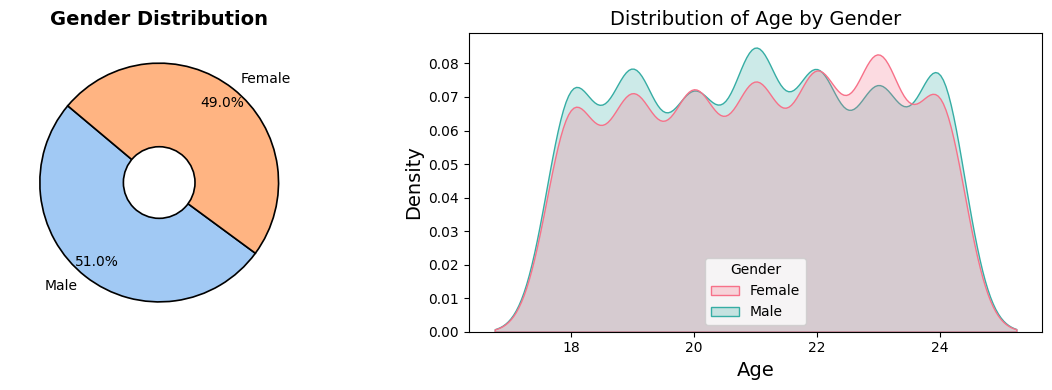

In [75]:
# Basic Data Analysis¶
#Age, Gender Distribution¶
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colors = sns.color_palette("pastel")
gender_counts = df['Gender'].value_counts()
wedges, texts, autotexts = axes[0].pie(
    gender_counts, labels=gender_counts.index, autopct='%1.1f%%',
    colors=colors, startangle=140, wedgeprops={'edgecolor': 'black', 'linewidth': 1.2}, pctdistance=0.85)
center_circle = plt.Circle((0, 0), 0.3, fc='white', edgecolor='black', linewidth=1.2)
axes[0].add_artist(center_circle)
axes[0].set_title("Gender Distribution", fontsize=14, fontweight="bold")

sns.kdeplot(x='Age', data=df, hue="Gender", fill=True, palette='husl', ax=axes[1])
axes[1].set_title('Distribution of Age by Gender', fontsize=14, color='k')
axes[1].set_xlabel("Age", fontsize=14, color='k')
axes[1].set_ylabel("Density", fontsize=14, color='k')
plt.tight_layout()
plt.show()

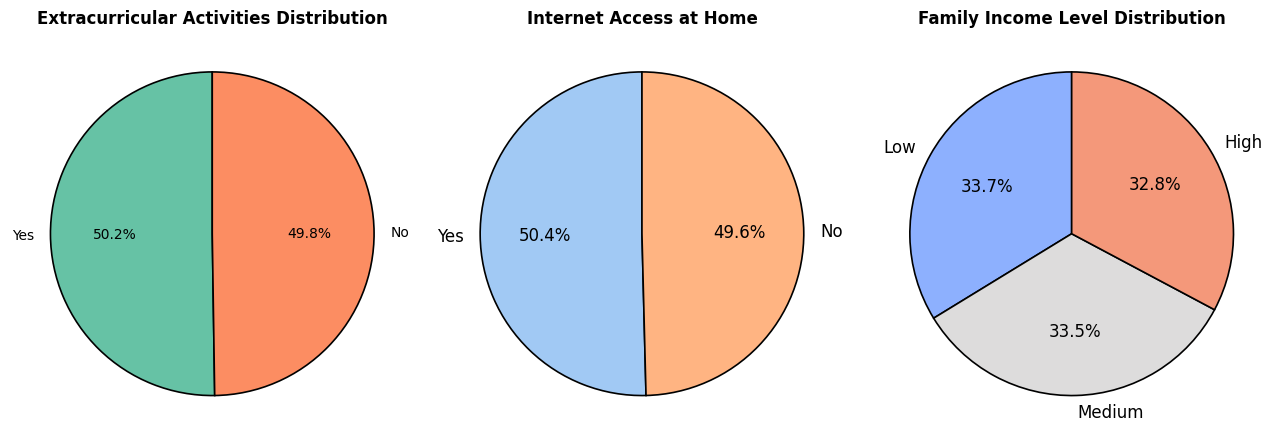

In [76]:
#Socioeconomic Factors¶
fig, axes = plt.subplots(1, 3, figsize=(13, 6))
df["Extracurricular_Activities"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", ax=axes[0], colors=sns.color_palette("Set2"),
    startangle=90, wedgeprops={'edgecolor': 'black', 'linewidth': 1.2}
)
axes[0].set_ylabel("")  
axes[0].set_title("Extracurricular Activities Distribution", fontsize=12, fontweight="bold")

internet_counts = df["Internet_Access_at_Home"].value_counts()
axes[1].pie(internet_counts, labels=internet_counts.index, autopct='%1.1f%%', 
            colors=sns.color_palette("pastel"), startangle=90, textprops={'fontsize': 12},
            wedgeprops={'edgecolor': 'black', 'linewidth': 1.2})
axes[1].set_title("Internet Access at Home", fontsize=12, fontweight="bold")

income_counts = df["Family_Income_Level"].value_counts()
axes[2].pie(income_counts, labels=income_counts.index, autopct='%1.1f%%', 
            colors=sns.color_palette("coolwarm", len(income_counts)), startangle=90, textprops={'fontsize': 12},
            wedgeprops={'edgecolor': 'black', 'linewidth': 1.2})
axes[2].set_title("Family Income Level Distribution", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()



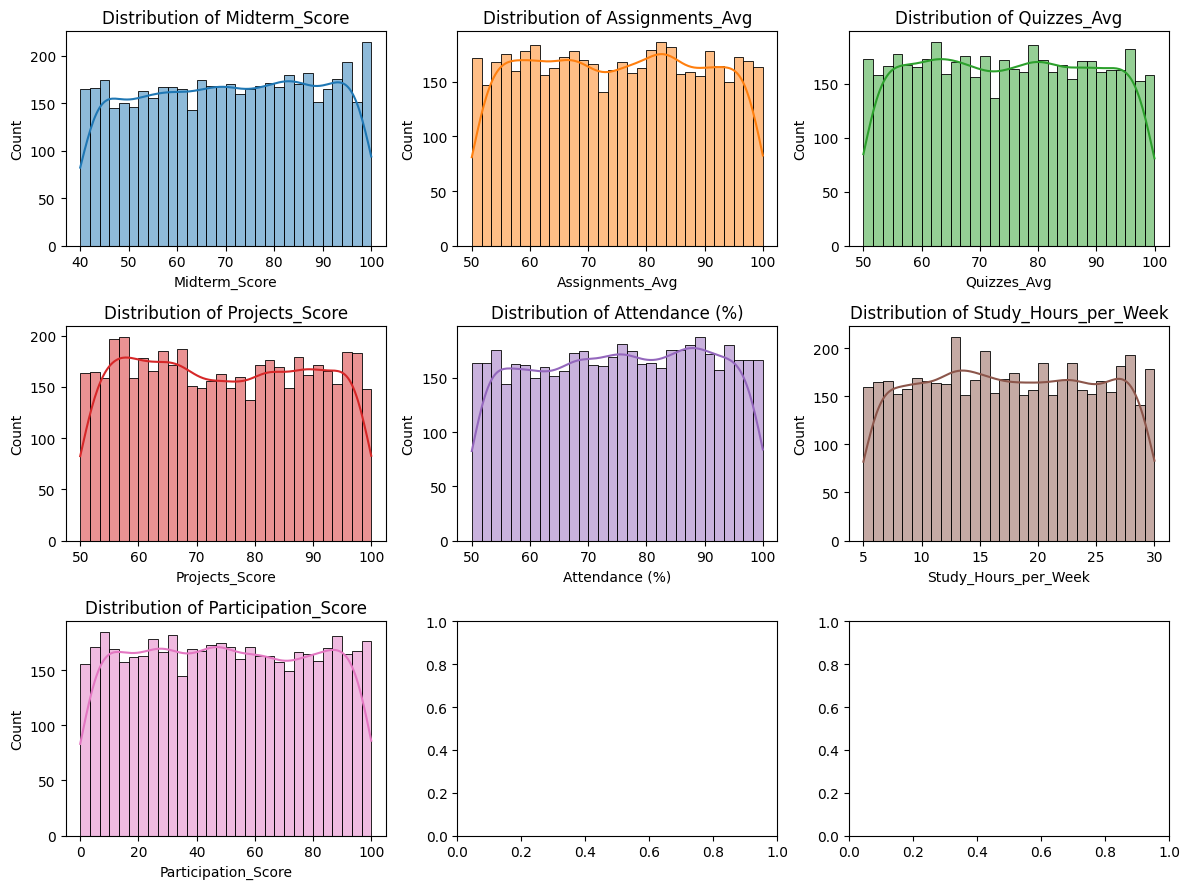

In [77]:
#Distibution of Various Academic Metrics¶
cols = ["Midterm_Score", "Assignments_Avg", "Quizzes_Avg", "Projects_Score",
         "Attendance (%)", "Study_Hours_per_Week", "Participation_Score"]
ncols = 3
nrows = int(np.ceil(len(cols) / ncols))

colors = sns.color_palette("tab10", len(cols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows * 3))
axes = axes.flatten()

for ax, col, color in zip(axes, cols, colors):
    sns.histplot(df[col], bins=30, kde=True, color=color, ax=ax)
    ax.set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


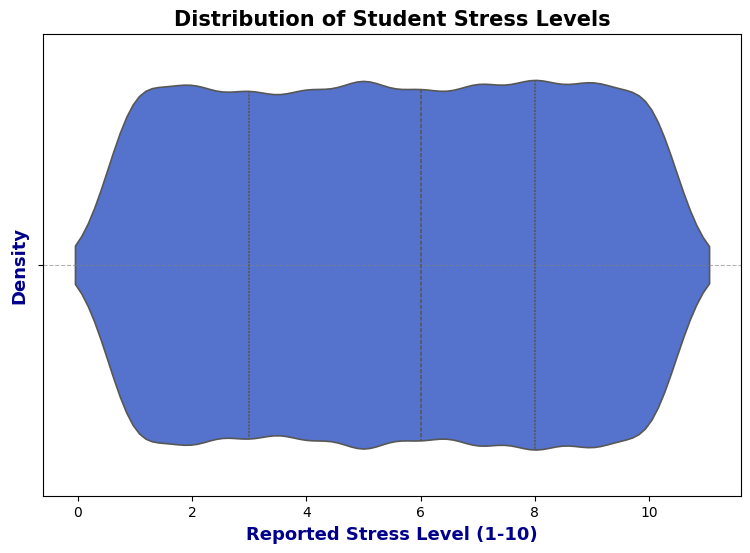

In [78]:
#Stress Levels¶
plt.figure(figsize=(9, 6))
sns.violinplot(x=df["Stress_Level (1-10)"], color="royalblue", inner="quartile", linewidth=1.2)

plt.xlabel("Reported Stress Level (1-10)", fontsize=13, fontweight="bold", color="darkblue")
plt.ylabel("Density", fontsize=13, fontweight="bold", color="darkblue")
plt.title("Distribution of Student Stress Levels", fontsize=15, fontweight="bold", color="black")
plt.grid(axis='y', linestyle="--", alpha=0.6, color="gray")

plt.show()

In [79]:
#High-level Correlations in current Data¶
def plot_numerical_correlation(df: DataFrame, title: str = "Correlation Heatmap of Continous Data", x: List[str] = None, only_total_score: bool = False):
    numeric_df = df.select_dtypes(include=['number'])
    if only_total_score:
        keep_cols = [col for col in numeric_df.columns if col not in academic_subscores]
        corr_data = numeric_df[keep_cols].corr()
        plt.figure(figsize=(10, len(keep_cols) * 0.5 + 2))
    else:
        corr_data = numeric_df.corr()
        plt.figure(figsize=(10, 6))

    sns.heatmap(corr_data, annot=True, cmap="RdBu_r", fmt=".2f", linewidths=1)
    plt.title(title)
    # plt.savefig(title.replace(" ", "_") + ".pdf")
    plt.show()

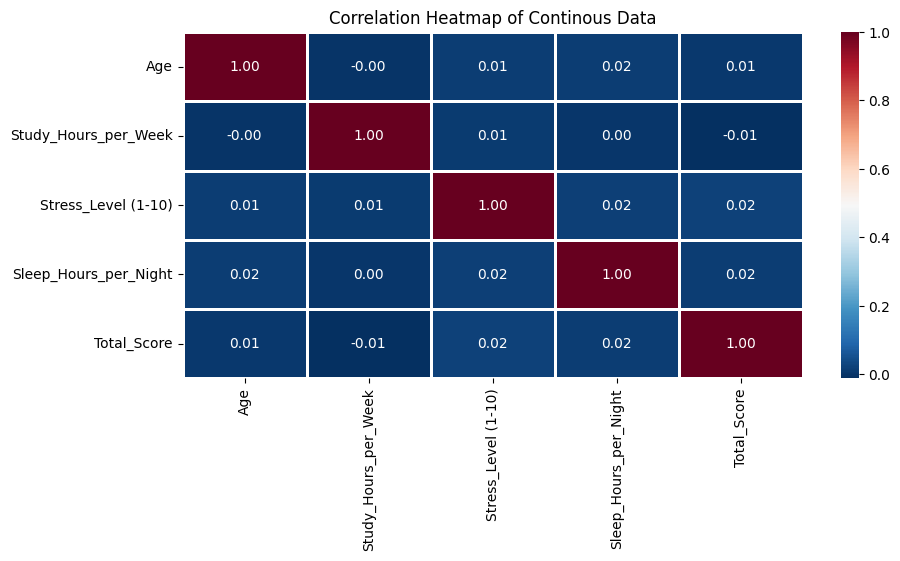

In [80]:
plot_numerical_correlation(df, only_total_score=True)

In [81]:
def regression_to_total_score(df: DataFrame, x_columns: List[str], figsize=(17, 4)):
    n = len(x_columns)
    cols = 3
    rows = math.ceil(n / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(figsize[0], figsize[1] * rows))
    axes = axes.flatten() if n > 1 else [axes]
    
    for i, x_col in enumerate(x_columns):
        sns.regplot(
            x=df[x_col], y=df["Total_Score"],
            scatter_kws={"s": 10}, line_kws={"color": "red"},
            ax=axes[i]
        )
        axes[i].set_title(f"Regression of Total Score vs {x_col.replace('_', ' ')}",
                          fontsize=14, fontweight="bold", color="darkred")
        axes[i].set_xlabel(x_col.replace("_", " "), fontsize=12)
        axes[i].set_ylabel("Total Score", fontsize=12)
        axes[i].grid(True, linestyle="--", alpha=0.6)
    
    # Hide unused axes
    for j in range(len(x_columns), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


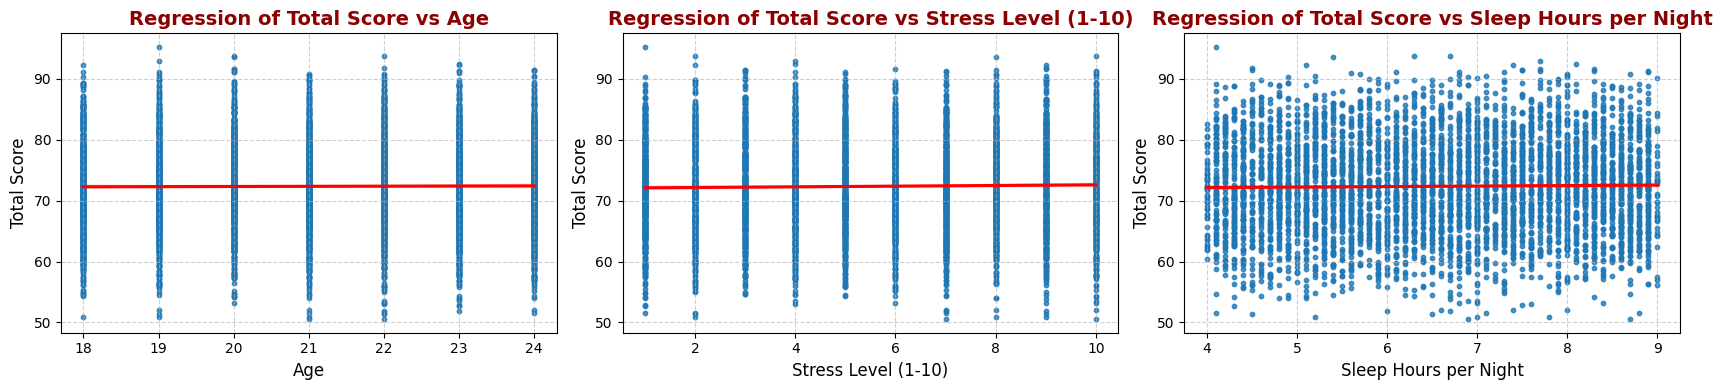

In [82]:
_cols = [col for col in df.select_dtypes(include=['number']).columns if col != 'Total_Score' and col != 'Study_Hours_per_Week' and col not in academic_subscores]
regression_to_total_score(df, _cols)


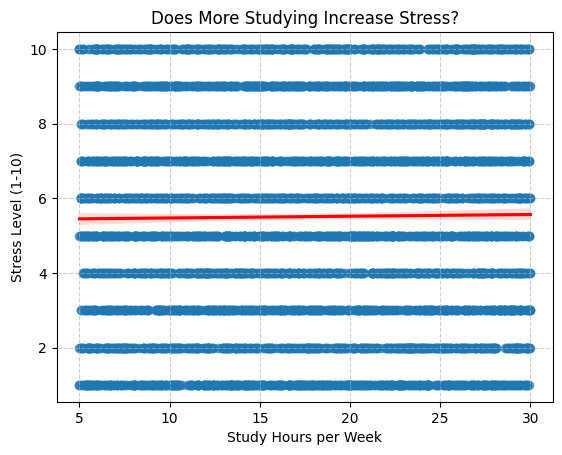

In [83]:
sns.regplot(x=df["Study_Hours_per_Week"], y=df["Stress_Level (1-10)"], scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title("Does More Studying Increase Stress?")
plt.xlabel("Study Hours per Week")
plt.ylabel("Stress Level (1-10)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


feature engineer

In [84]:
# How consistent is the student across subscores (higher = more consistant performance across the field)
df["Consistency_Score"] = df[academic_subscores].std(axis=1)

In [85]:
academic_subscores

['Attendance (%)',
 'Participation_Score',
 'Quizzes_Avg',
 'Assignments_Avg',
 'Midterm_Score',
 'Projects_Score']

In [86]:
# (sleep+play)-study balance = sleep hours & whether a student participates in outside activities, divided by study hours
#                                              (higher = prioritizing sleep and extracurricular activities)
# This is similar to the notion of "work-life balance"
df["Sleep_Play_Study_Balance"] = df.apply(
    lambda row: (row["Sleep_Hours_per_Night"] + (2 if row["Extracurricular_Activities"] == "Yes" else 0)) / (row["Study_Hours_per_Week"] / 7),
    axis=1
)

In [87]:
# How enjoyable is the student's life while studying (higher = happier)
income_bonus = {
    'Low': 0,
    'Medium': 5,
    'High': 10,
}
df["Happiness_Score"] = df.apply(
    lambda row:
        row["Participation_Score"] +  # engaged with the content of the class
        (1 - row["Study_Hours_per_Week"] / 168) * 1000 +  # doesn't spend much time studying outside of class
        (10 if row["Extracurricular_Activities"] == "Yes" else 0) +  # participates in extracurricular activities
        (10 if row["Internet_Access_at_Home"] == "Yes" else 0) +  # has internet at home
        income_bonus.get(row["Family_Income_Level"], 0) +  # parents are rich
        (10 - row["Stress_Level (1-10)"]) +  # is not stressed
        row["Sleep_Hours_per_Night"],  # gets to sleep a lot
    axis=1
)


In [88]:
#df["Academic_Efficiency"] = df["Total_Score"] / (df["Study_Hours_per_Week"] + 1)
df["Engagement_Index"] = (
    df["Attendance (%)"] * 0.5 +
    df["Participation_Score"] * 0.3 +
    (df["Extracurricular_Activities"].map({"Yes": 1, "No": 0}) * 20)
    
)
#df["Stress_Performance_Ratio"] = df["Stress_Level (1-10)"] / (df["Total_Score"] + 1)

df["Consistency_Index"] = 1 / (1 + df[academic_subscores].std(axis=1))
df["Wellness_Index"] = (
    (df["Sleep_Hours_per_Night"] * 10) +
    (10 - df["Stress_Level (1-10)"]) * 5 +
    (df["Extracurricular_Activities"].map({"Yes": 1, "No": 0}) * 10)
)

In [89]:
new_features = [
    "Consistency_Score",
    "Sleep_Play_Study_Balance",
    "Happiness_Score",
    "Consistency_Index",
    #"Academic_Efficiency",
    "Engagement_Index",
    #"Stress_Performance_Ratio",
    "Wellness_Index"
]

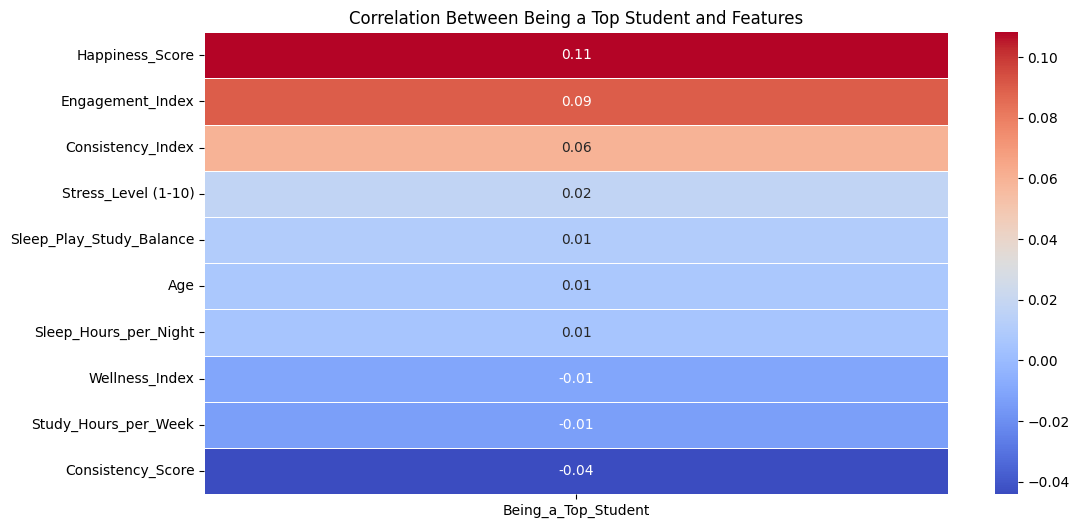

In [90]:
#Analysis under new lens
# We flag students whose grade is B+ or above as the "Top students"
#        B+ students have Total_Score >= 80 (from the official link, cited above, section 1.2.2)
df["Being_a_Top_Student"] = (df["Total_Score"] >=70)
_cols = [col for col in df.select_dtypes(include=['number']).columns if col not in academic_subscores and col != 'Total_Score']
df["Being_a_Top_Student"] = df["Being_a_Top_Student"].astype(int)
numerical_to_numerical_correlation(df, _cols, 'Being_a_Top_Student', 'Features')


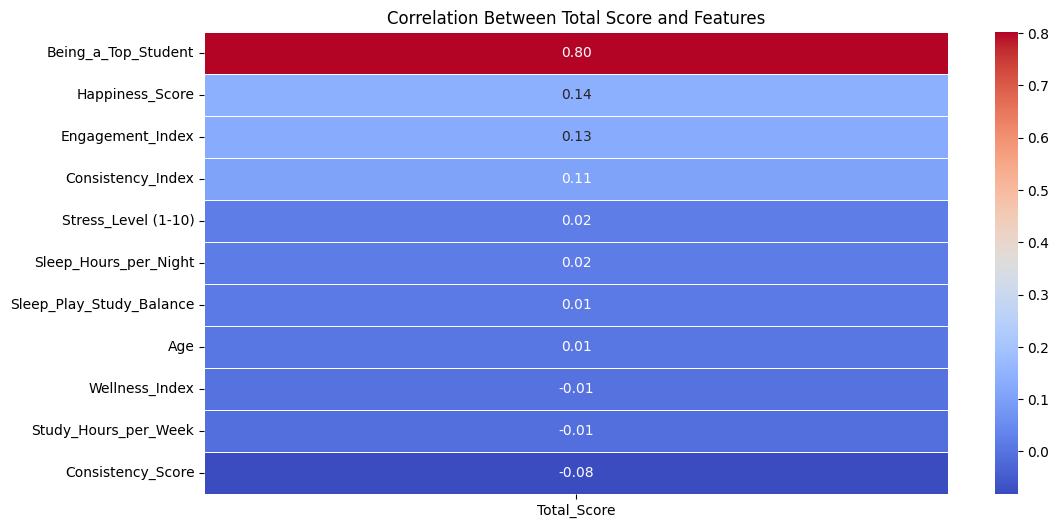

In [91]:
#Analysis under new lens
# We flag students whose grade is B+ or above as the "Top students"
#        B+ students have Total_Score >= 80 (from the official link, cited above, section 1.2.2)
_cols = [col for col in df.select_dtypes(include=['number']).columns if col not in academic_subscores and col != 'Total_Score']
numerical_to_numerical_correlation(df, _cols, 'Total_Score', 'Features')

In [92]:
useless_columns = ['Being_a_Top_Student','Total_Score']
for col in useless_columns:
    df = safe_drop(df, col)

creat copy to make sure that data are saved

In [93]:
df2=df.copy()

In [94]:
df2=df.copy()
useless_columns = ["Gender", "Age", "Department","Grade",
    "Extracurricular_Activities", "Internet_Access_at_Home",
    "Parent_Education_Level", "Family_Income_Level", "Stress_Level (1-10)",
    "Consistency_Score",
    "Sleep_Play_Study_Balance",
    "Happiness_Score",
    "Consistency_Index",
    "Sleep_Hours_per_Night",
    "Engagement_Index",
    "Study_Hours_per_Week",
    "Wellness_Index","Risk_Level"]

for col in useless_columns:
    df2= safe_drop(df2, col)


In [95]:
df3=df2.copy()

In [96]:
df1=df.copy()

In [97]:
useless_columns = ["Gender", "Age", "Department","Grade",
    
    "Consistency_Index",
'Attendance (%)',
 'Participation_Score',
 'Quizzes_Avg',
 'Assignments_Avg',
 'Midterm_Score',
 'Projects_Score',"Risk_Level"]
for col in useless_columns:
    df1 = safe_drop(df1, col)


Baseline Model

In [ ]:
# Define features (X) and label (y)
X = df[[ 'Attendance (%)',
 'Participation_Score',
 'Quizzes_Avg',
 'Assignments_Avg',
 'Midterm_Score',
 'Projects_Score']]
y = df['Risk_Level']
# Initial Baseline Training (Single Train/Test Split)
#first trained all baseline models using a standard train/test split.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y
)


In [99]:
print(f"X_train shape: {X_train.shape}  -> ({X_train.shape[0]} samples, {X_train.shape[1]} features)")
print(f"X_test  shape: {X_test.shape}   -> ({X_test.shape[0]} samples, {X_test.shape[1]} features)")
print(f"y_train shape: {y_train.shape}  -> {len(np.unique(y_train))} unique classes")
print(f"y_test  shape: {y_test.shape}   -> {len(np.unique(y_test))} unique classes")
print(f"\nTotal samples: {len(y)}  |  Train: {len(y_train)}  |  Test: {len(y_test)}")


X_train shape: (4000, 6)  -> (4000 samples, 6 features)
X_test  shape: (1000, 6)   -> (1000 samples, 6 features)
y_train shape: (4000,)  -> 3 unique classes
y_test  shape: (1000,)   -> 3 unique classes

Total samples: 5000  |  Train: 4000  |  Test: 1000


In [100]:
from sklearn.preprocessing import LabelEncoder
# Convert labels into integer classes for classical ML models.
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


In [101]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [102]:
X_train_scaled

array([[ 1.29713603,  0.90090452,  1.42709785,  0.78218232, -0.49150611,
         1.11730021],
       [-0.31345231,  1.5104574 ,  1.51551224,  0.46489712, -1.70368864,
         1.53260551],
       [ 0.87238078,  1.47601939, -0.8357579 , -0.79800882,  1.33935882,
         1.41414363],
       ...,
       [-1.62671198, -0.51105413, -0.30803452, -0.74189507, -1.25040792,
         0.15169818],
       [-1.72767839,  1.37270534, -0.28593092, -1.23999126, -1.42668375,
        -1.26571193],
       [-0.85518933, -1.08272519, -0.22790898, -1.24830441,  0.63311083,
         0.99470594]])

In [103]:
from tensorflow.keras.utils import to_categorical
import numpy as np

num_classes = len(np.unique(y_train))   # y_train, NOT y (important!)
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)


In [104]:
y_train

array([1, 1, 1, ..., 2, 0, 1])

In [105]:
def print_model_results(y_train, y_train_pred, y_train_proba,
                        y_test, y_test_pred, y_test_proba,
                        model_name="Model"):
    print(" Function executed successfully!")
    print(f"\n=== {model_name.upper()} RESULTS ===")

    print("\n[TRAIN RESULTS]")
    print(classification_report(y_train, y_train_pred))
    try:
        print("ROC AUC (train):", round(
            roc_auc_score(y_train, y_train_proba, multi_class='ovr'), 4))
    except ValueError:
        print("ROC AUC (train): Not applicable for multiclass with this input")

    print("\n[TEST RESULTS]")
    print(classification_report(y_test, y_test_pred))
    try:
        print("ROC AUC (test):", round(
            roc_auc_score(y_test, y_test_proba, multi_class='ovr'), 4))
    except ValueError:
        print("ROC AUC (test): Not applicable for multiclass with this input")

In [106]:
def get_feature_importance(model, feature_names, top_n=None):
    """
    Returns a DataFrame with features and their importance values.
    Works for Logistic Regression, Random Forest, XGBoost, LightGBM (multi-class compatible).
    """
    if hasattr(model, "coef_"):
        importance = np.mean(np.abs(model.coef_), axis=0)
    elif hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
    else:
        raise ValueError("This model type does not support feature importance.")

    fi = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importance
    }).sort_values(by="Importance", ascending=False)

    if top_n:
        fi = fi.head(top_n)

    return fi.reset_index(drop=True)


This included Logistic Regression, Random Forest, XGBoost, LightGBM, MLP, CNN, and TabNet.Each model was assessed using accuracy, precision, recall, F1-score, and ROC-AUC (when applicable).

In [ ]:
logi_model = LogisticRegression(
    class_weight='balanced',
    random_state=42
)
logi_model.fit(X_train_scaled, y_train)

#  Predictions
y_train_pred_logi = logi_model.predict(X_train_scaled)
y_test_pred_logi  = logi_model.predict(X_test_scaled)


y_train_proba_logi = logi_model.predict_proba(X_train_scaled)
y_test_proba_logi  = logi_model.predict_proba(X_test_scaled)

#Evaluate 
print_model_results(y_train, y_train_pred_logi, y_train_proba_logi,
                    y_test, y_test_pred_logi, y_test_proba_logi,
                    model_name="Logistic Regression")


 Function executed successfully!

=== LOGISTIC REGRESSION RESULTS ===

[TRAIN RESULTS]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       223
           1       1.00      0.98      0.99      2418
           2       0.96      0.97      0.96      1359

    accuracy                           0.97      4000
   macro avg       0.93      0.98      0.95      4000
weighted avg       0.98      0.97      0.98      4000

ROC AUC (train): 0.9994

[TEST RESULTS]
              precision    recall  f1-score   support

           0       0.81      1.00      0.90        56
           1       1.00      0.99      0.99       605
           2       0.98      0.96      0.97       339

    accuracy                           0.98      1000
   macro avg       0.93      0.98      0.95      1000
weighted avg       0.98      0.98      0.98      1000

ROC AUC (test): 0.9996


Logistic regression is actually more stable on this dataset.
It handles unseen/test data much better than Random Forest.
It is less sensitive to out-of-range inputs (but still not perfect).

In [108]:
logi_importance = get_feature_importance(logi_model, X.columns, top_n=10)
print("\nTop Features (Logistic Regression):\n", logi_importance.to_string(index=False))


Top Features (Logistic Regression):
             Feature  Importance
     Projects_Score    6.192634
      Midterm_Score    3.751532
    Assignments_Avg    3.042657
        Quizzes_Avg    2.030972
Participation_Score    2.010585
     Attendance (%)    0.031007


In [109]:
import pandas as pd

# 10 high-risk students
test_high_risk = pd.DataFrame({
    "Attendance (%)": [50, 55, 52, 51, 53, 50, 54, 56, 52, 50],
    "Midterm_Score": [40, 45, 42, 41, 44, 43, 40, 45, 42, 41],
    "Assignments_Avg": [50, 52, 48, 49, 51, 47, 50, 52, 48, 49],
    "Quizzes_Avg": [50, 55, 53, 51, 52, 50, 54, 56, 52, 51],
    "Participation_Score": [5, 8, 4, 6, 7, 3, 5, 8, 4, 6],
    "Projects_Score": [50, 52, 49, 48, 51, 47, 50, 53, 49, 48]
})

test_high_risk
preds = logi_model.predict(test_high_risk)
probs = logi_model.predict_proba(test_high_risk)

print("Predictions:", preds)
print("\nProbabilities:\n", probs)


Predictions: [1 1 1 1 1 1 1 1 1 1]

Probabilities:
 [[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    random_state=42
)

rf_model.fit(X_train_scaled, y_train)

#  Predictions 
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf  = rf_model.predict(X_test_scaled)

#  Probabilities (multi-class compatible) 
y_train_proba_rf = rf_model.predict_proba(X_train_scaled)
y_test_proba_rf  = rf_model.predict_proba(X_test_scaled)

#  Evaluation 
print_model_results(y_train, y_train_pred_rf, y_train_proba_rf,
                    y_test, y_test_pred_rf, y_test_proba_rf,
                    model_name="Random Forest")

# Feature Importance 
rf_importance = get_feature_importance(rf_model, X.columns, top_n=10)
print("\nTop Features (Random Forest):\n", rf_importance.to_string(index=False))


 Function executed successfully!

=== RANDOM FOREST RESULTS ===

[TRAIN RESULTS]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       1.00      1.00      1.00      2418
           2       1.00      1.00      1.00      1359

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

ROC AUC (train): 1.0

[TEST RESULTS]
              precision    recall  f1-score   support

           0       0.95      0.64      0.77        56
           1       0.95      0.97      0.96       605
           2       0.88      0.90      0.89       339

    accuracy                           0.93      1000
   macro avg       0.93      0.84      0.87      1000
weighted avg       0.93      0.93      0.92      1000

ROC AUC (test): 0.9885

Top Features (Random Forest):
             Feature  Importance
     Projects_Score    0.388663
 

 Random Forest is weak at detecting minority/rare class 0
and its performance collapses under distribution shift.
Random Forests cannot extrapolate outside the training feature ranges.

In [111]:
import pandas as pd

# 10 high-risk students
test_high_risk = pd.DataFrame({
    "Attendance (%)": [50, 55, 52, 51, 53, 50, 54, 56, 52, 50],
    "Midterm_Score": [40, 45, 42, 41, 44, 43, 40, 45, 42, 41],
    "Assignments_Avg": [50, 52, 48, 49, 51, 47, 50, 52, 48, 49],
    "Quizzes_Avg": [50, 55, 53, 51, 52, 50, 54, 56, 52, 51],
    "Participation_Score": [5, 8, 4, 6, 7, 3, 5, 8, 4, 6],
    "Projects_Score": [50, 52, 49, 48, 51, 47, 50, 53, 49, 48]
})

test_high_risk
preds = logi_model.predict(test_high_risk)
probs = rf_model.predict_proba(test_high_risk)

print("Predictions:", preds)
print("\nProbabilities:\n", probs)


Predictions: [1 1 1 1 1 1 1 1 1 1]

Probabilities:
 [[0.   0.99 0.01]
 [0.   0.99 0.01]
 [0.   0.99 0.01]
 [0.   0.99 0.01]
 [0.   0.99 0.01]
 [0.   0.99 0.01]
 [0.   0.99 0.01]
 [0.   0.99 0.01]
 [0.   0.99 0.01]
 [0.   0.99 0.01]]


In [ ]:
xgb_model = XGBClassifier(
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train_scaled)
y_test_pred_xgb  = xgb_model.predict(X_test_scaled)

#  Probabilities (multi-class) 
y_train_proba_xgb = xgb_model.predict_proba(X_train_scaled)
y_test_proba_xgb  = xgb_model.predict_proba(X_test_scaled)

# Evaluation 
print_model_results(y_train, y_train_pred_xgb, y_train_proba_xgb,
                    y_test, y_test_pred_xgb, y_test_proba_xgb,
                    model_name="XGBoost")

#  Feature Importance 
xgb_importance = get_feature_importance(xgb_model, X.columns, top_n=10)
print("\nTop Features (XGBoost):\n", xgb_importance.to_string(index=False))


 Function executed successfully!

=== XGBOOST RESULTS ===

[TRAIN RESULTS]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       1.00      1.00      1.00      2418
           2       1.00      1.00      1.00      1359

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

ROC AUC (train): 1.0

[TEST RESULTS]
              precision    recall  f1-score   support

           0       0.98      0.86      0.91        56
           1       0.96      0.97      0.96       605
           2       0.92      0.92      0.92       339

    accuracy                           0.95      1000
   macro avg       0.95      0.91      0.93      1000
weighted avg       0.95      0.95      0.95      1000

ROC AUC (test): 0.9926

Top Features (XGBoost):
             Feature  Importance
     Projects_Score    0.370246
      Midterm

In [113]:
import pandas as pd

# 10 high-risk students
test_high_risk = pd.DataFrame({
    "Attendance (%)": [50, 55, 52, 51, 53, 50, 54, 56, 52, 50],
    "Midterm_Score": [40, 45, 42, 41, 44, 43, 40, 45, 42, 41],
    "Assignments_Avg": [50, 52, 48, 49, 51, 47, 50, 52, 48, 49],
    "Quizzes_Avg": [50, 55, 53, 51, 52, 50, 54, 56, 52, 51],
    "Participation_Score": [5, 8, 4, 6, 7, 3, 5, 8, 4, 6],
    "Projects_Score": [50, 52, 49, 48, 51, 47, 50, 53, 49, 48]
})

test_high_risk
preds = xgb_model.predict(test_high_risk)
probs = xgb_model.predict_proba(test_high_risk)

print("Predictions:", preds)
print("\nProbabilities:\n", probs)


Predictions: [1 1 1 1 1 1 1 1 1 1]

Probabilities:
 [[2.0422847e-08 1.0000000e+00 3.0920063e-08]
 [2.0422847e-08 1.0000000e+00 3.0920063e-08]
 [2.0422847e-08 1.0000000e+00 3.0920063e-08]
 [2.0422847e-08 1.0000000e+00 3.0920063e-08]
 [2.0422847e-08 1.0000000e+00 3.0920063e-08]
 [2.0422847e-08 1.0000000e+00 3.0920063e-08]
 [2.0422847e-08 1.0000000e+00 3.0920063e-08]
 [2.0422847e-08 1.0000000e+00 3.0920063e-08]
 [2.0422847e-08 1.0000000e+00 3.0920063e-08]
 [2.0422847e-08 1.0000000e+00 3.0920063e-08]]


In [ ]:
lgb_model = LGBMClassifier(
    random_state=42
)
lgb_model.fit(X_train_scaled, y_train)

y_train_pred_lgb = lgb_model.predict(X_train_scaled)
y_test_pred_lgb  = lgb_model.predict(X_test_scaled)
y_train_proba_lgb = lgb_model.predict_proba(X_train_scaled)
y_test_proba_lgb  = lgb_model.predict_proba(X_test_scaled)

print_model_results(y_train, y_train_pred_lgb, y_train_proba_lgb,
                    y_test, y_test_pred_lgb, y_test_proba_lgb,
                    model_name="LightGBM")

lgb_importance = get_feature_importance(lgb_model, X.columns, top_n=10)
print("\nTop Features (LightGBM):\n", lgb_importance.to_string(index=False))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 6
[LightGBM] [Info] Start training from score -2.886878
[LightGBM] [Info] Start training from score -0.503354
[LightGBM] [Info] Start training from score -1.079545
 Function executed successfully!

=== LIGHTGBM RESULTS ===

[TRAIN RESULTS]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       1.00      1.00      1.00      2418
           2       1.00      1.00      1.00      1359

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

ROC AUC (train): 1.0

[TEST RE

In [115]:
import pandas as pd

# 10 high-risk students
test_high_risk = pd.DataFrame({
    "Attendance (%)": [50, 55, 52, 51, 53, 50, 54, 56, 52, 50],
    "Midterm_Score": [40, 45, 42, 41, 44, 43, 40, 45, 42, 41],
    "Assignments_Avg": [50, 52, 48, 49, 51, 47, 50, 52, 48, 49],
    "Quizzes_Avg": [50, 55, 53, 51, 52, 50, 54, 56, 52, 51],
    "Participation_Score": [5, 8, 4, 6, 7, 3, 5, 8, 4, 6],
    "Projects_Score": [50, 52, 49, 48, 51, 47, 50, 53, 49, 48]
})

test_high_risk
preds = lgb_model.predict(test_high_risk)
probs = lgb_model.predict_proba(test_high_risk)

print("Predictions:", preds)
print("\nProbabilities:\n", probs)

Predictions: [1 1 1 1 1 1 1 1 1 1]

Probabilities:
 [[3.29967544e-07 9.99994064e-01 5.60560807e-06]
 [3.29967544e-07 9.99994064e-01 5.60560807e-06]
 [3.29967544e-07 9.99994064e-01 5.60560807e-06]
 [3.29967544e-07 9.99994064e-01 5.60560807e-06]
 [3.29967544e-07 9.99994064e-01 5.60560807e-06]
 [3.29967544e-07 9.99994064e-01 5.60560807e-06]
 [3.29967544e-07 9.99994064e-01 5.60560807e-06]
 [3.29967544e-07 9.99994064e-01 5.60560807e-06]
 [3.29967544e-07 9.99994064e-01 5.60560807e-06]
 [3.29967544e-07 9.99994064e-01 5.60560807e-06]]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

print("\n=== MLP BASELINE MODEL ===")

mlp = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mlp.fit(X_train_scaled, y_train_cat, epochs=30, batch_size=16, verbose=0)

y_pred_mlp = np.argmax(mlp.predict(X_test_scaled), axis=1)
print("Accuracy (MLP):", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))


=== MLP BASELINE MODEL ===
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy (MLP): 0.99
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        56
           1       0.99      1.00      0.99       605
           2       0.99      0.98      0.99       339

    accuracy                           0.99      1000
   macro avg       0.99      0.98      0.98      1000
weighted avg       0.99      0.99      0.99      1000



In [ ]:
X_custom = test_high_risk[
    ["Attendance (%)",
     "Participation_Score",
     "Quizzes_Avg",
     "Assignments_Avg",
     "Midterm_Score",
     "Projects_Score"]
]

X_custom = X_custom.to_numpy()

X_custom_scaled = scaler.transform(X_custom)

probs = mlp.predict(X_custom_scaled)
preds = probs.argmax(axis=1)

print("Predictions:", preds)
print("\nProbabilities:\n", probs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predictions: [0 0 0 0 0 0 0 0 0 0]

Probabilities:
 [[1.0000000e+00 0.0000000e+00 7.6718215e-11]
 [1.0000000e+00 2.5064849e-36 3.5476186e-09]
 [1.0000000e+00 0.0000000e+00 7.1395299e-11]
 [1.0000000e+00 0.0000000e+00 3.6554006e-11]
 [1.0000000e+00 0.0000000e+00 7.2494755e-10]
 [1.0000000e+00 0.0000000e+00 1.4091132e-11]
 [1.0000000e+00 0.0000000e+00 1.5940058e-10]
 [1.0000000e+00 2.2876120e-35 7.0496324e-09]
 [1.0000000e+00 0.0000000e+00 6.1065424e-11]
 [1.0000000e+00 0.0000000e+00 3.5661085e-11]]


In [118]:
# CNN Baseline Model
# ملاحظة: هذا مجرد مثال، لأن CNN تحتاج بيانات بشكل مصفوفة (مثل الصور)
# سنحوّل البيانات إلى شكل (عينات، صفات، 1، 1) لتجربتها فقط
print("\n=== CNN BASELINE MODEL ===")

X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1, 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1, 1))
cnn = Sequential([
    Conv2D(16, (2,1), activation='relu', input_shape=(X_train_scaled.shape[1],1,1)),
    MaxPooling2D((2,1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn.fit(X_train_cnn, y_train_cat, epochs=20, batch_size=16, verbose=0)
y_pred_cnn = np.argmax(cnn.predict(X_test_cnn), axis=1)
print("Accuracy (CNN):", accuracy_score(y_test, y_pred_cnn))
print(classification_report(y_test, y_pred_cnn))


=== CNN BASELINE MODEL ===
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy (CNN): 0.663
              precision    recall  f1-score   support

           0       0.44      0.12      0.19        56
           1       0.76      0.79      0.77       605
           2       0.51      0.53      0.52       339

    accuracy                           0.66      1000
   macro avg       0.57      0.48      0.49      1000
weighted avg       0.65      0.66      0.65      1000



In [119]:
#  TabNet Baseline Model
print("\n=== TABNET BASELINE MODEL ===")
tabnet = TabNetClassifier(optimizer_fn=torch.optim.Adam,seed=42)
tabnet.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    eval_metric=['accuracy'],
    max_epochs=50, patience=10, batch_size=32, virtual_batch_size=16
)
y_pred_tabnet = tabnet.predict(X_test_scaled)
print("Accuracy (TabNet):", accuracy_score(y_test, y_pred_tabnet))
print(classification_report(y_test, y_pred_tabnet))



=== TABNET BASELINE MODEL ===
epoch 0  | loss: 0.5045  | val_0_accuracy: 0.897   |  0:00:04s
epoch 1  | loss: 0.35412 | val_0_accuracy: 0.832   |  0:00:09s
epoch 2  | loss: 0.31734 | val_0_accuracy: 0.929   |  0:00:15s
epoch 3  | loss: 0.29505 | val_0_accuracy: 0.897   |  0:00:20s
epoch 4  | loss: 0.29898 | val_0_accuracy: 0.902   |  0:00:25s
epoch 5  | loss: 0.2704  | val_0_accuracy: 0.962   |  0:00:30s
epoch 6  | loss: 0.27802 | val_0_accuracy: 0.92    |  0:00:35s
epoch 7  | loss: 0.2817  | val_0_accuracy: 0.912   |  0:00:40s
epoch 8  | loss: 0.25849 | val_0_accuracy: 0.927   |  0:00:47s
epoch 9  | loss: 0.24081 | val_0_accuracy: 0.925   |  0:00:54s
epoch 10 | loss: 0.26299 | val_0_accuracy: 0.959   |  0:01:01s
epoch 11 | loss: 0.27068 | val_0_accuracy: 0.93    |  0:01:07s
epoch 12 | loss: 0.26434 | val_0_accuracy: 0.943   |  0:01:13s
epoch 13 | loss: 0.2703  | val_0_accuracy: 0.877   |  0:01:20s
epoch 14 | loss: 0.27053 | val_0_accuracy: 0.932   |  0:01:27s
epoch 15 | loss: 0.25021

In [ ]:
import pandas as pd

# 10 high-risk students
test_high_risk = pd.DataFrame({
    "Attendance (%)": [50, 55, 52, 51, 53, 50, 54, 56, 52, 50],
    "Midterm_Score": [40, 45, 42, 41, 44, 43, 40, 45, 42, 41],
    "Assignments_Avg": [50, 52, 48, 49, 51, 47, 50, 52, 48, 49],
    "Quizzes_Avg": [50, 55, 53, 51, 52, 50, 54, 56, 52, 51],
    "Participation_Score": [5, 8, 4, 6, 7, 3, 5, 8, 4, 6],
    "Projects_Score": [50, 52, 49, 48, 51, 47, 50, 53, 49, 48]
})

import pandas as pd

X_custom = test_high_risk[
    ["Attendance (%)",
     "Participation_Score",
     "Quizzes_Avg",
     "Assignments_Avg",
     "Midterm_Score",
     "Projects_Score"]
]

# --- 2) numpy ---
X_custom = X_custom.to_numpy()

# --- 3) scaling ---
X_custom_scaled = scaler.transform(X_custom)

probs = tabnet.predict_proba(X_custom_scaled)
preds = probs.argmax(axis=1)

print("Predictions:", preds)
print("\nProbabilities:\n", probs)



Predictions: [0 0 0 0 0 0 0 0 0 0]

Probabilities:
 [[9.9965107e-01 3.6620651e-11 3.4897818e-04]
 [9.9892515e-01 7.1485151e-10 1.0748791e-03]
 [9.9966943e-01 3.2620049e-11 3.3062519e-04]
 [9.9972576e-01 1.8511677e-11 2.7419758e-04]
 [9.9933916e-01 1.9482779e-10 6.6079089e-04]
 [9.9979526e-01 8.7141353e-12 2.0474280e-04]
 [9.9957865e-01 6.4807833e-11 4.2131575e-04]
 [9.9867994e-01 1.2616616e-09 1.3200305e-03]
 [9.9968445e-01 2.8309232e-11 3.1559184e-04]
 [9.9972576e-01 1.8511677e-11 2.7419758e-04]]


Baseline Model with Cross-validation

In [ ]:
from sklearn.preprocessing import LabelEncoder
#  Create encoder
encoder = LabelEncoder()
# Fit and transform labels
y = encoder.fit_transform(y)
# Extract mapping
label_map = {label: idx for idx, label in enumerate(encoder.classes_)}
print("Label Mapping:", label_map)


Label Mapping: {'High Risk': 0, 'Low Risk': 1, 'Moderate Risk': 2}


In [ ]:
# Prepare data
num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes)
X_np = X.values if hasattr(X, "values") else X
y_np = y.values if hasattr(y, "values") else y
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#  Helper metrics
def evaluate_model(name, preds, trues):
    acc = accuracy_score(trues, preds)
    bacc = balanced_accuracy_score(trues, preds)
    f1 = f1_score(trues, preds, average='macro')
    print(f"{name:10s} | Acc={acc:.3f} | BAcc={bacc:.3f} | MacroF1={f1:.3f}")
    return {"Model": name, "Acc": acc, "BAcc": bacc, "MacroF1": f1}

In [ ]:
# Cross-validation loop
results = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X_np, y_np), 1):
    print(f"\n===== Fold {fold} =====")

    X_train, X_test = X_np[train_idx], X_np[test_idx]
    y_train, y_test = y_np[train_idx], y_np[test_idx]
    y_train_cat = to_categorical(y_train, num_classes)
    y_test_cat  = to_categorical(y_test, num_classes)

    # === XGBoost ===
    xgb = XGBClassifier(
        use_label_encoder=False, eval_metric='logloss',
        random_state=42, n_estimators=200
    )
    xgb.fit(X_train, y_train)
    preds = xgb.predict(X_test)
    results.append(evaluate_model("XGBoost", preds, y_test))

    # === LightGBM ===
    lgb = LGBMClassifier(is_unbalance=True, random_state=42)
    lgb.fit(X_train, y_train)
    preds = lgb.predict(X_test)
    results.append(evaluate_model("LightGBM", preds, y_test))

    # === MLP (Keras) ===
    tf.keras.backend.clear_session()
    mlp = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    mlp.fit(X_train, y_train_cat, epochs=10, batch_size=16, verbose=0)
    preds = np.argmax(mlp.predict(X_test), axis=1)
    results.append(evaluate_model("MLP", preds, y_test))

    # === TabNet (PyTorch) ===
    tabnet = TabNetClassifier(optimizer_fn=torch.optim.Adam)
    tabnet.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['accuracy'],
        max_epochs=20, patience=5, batch_size=32,
        
    )
    preds = tabnet.predict(X_test)
    results.append(evaluate_model("TabNet", preds, y_test))


===== Fold 1 =====
XGBoost    | Acc=0.944 | BAcc=0.891 | MacroF1=0.915
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 6
[LightGBM] [Info] Start training from score -2.886878
[LightGBM] [Info] Start training from score -0.503354
[LightGBM] [Info] Start training from score -1.079545
LightGBM   | Acc=0.938 | BAcc=0.888 | MacroF1=0.908

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MLP        | Acc=0.750 | BAcc=0.562 | MacroF1=0.590
epoch 0  | loss: 0.4821  | val_0_accuracy: 0.605   |  0:00:05s
epoch 1  | loss: 0.30335 | val_0_accuracy: 0.78    |  0:00:10s
epoch 2  | loss: 0.25363 | val_0_accuracy: 0.895   |  0:00:14s
epoch 3  | loss: 0.23022 | val_0_accuracy: 0.892   |  0:00:18s
epoch 4  | loss: 0.23521 | val_0_accuracy: 0.929   |  0:00:22s
epoch 5  | loss: 0.2

In [124]:
# Aggregate and summarize results
df_results = pd.DataFrame(results)
summary = df_results.groupby("Model").agg(["mean", "std"])
print("\n=== Cross-Validation Generalization Results ===")
print(summary.round(4))


=== Cross-Validation Generalization Results ===
             Acc            BAcc         MacroF1        
            mean     std    mean     std    mean     std
Model                                                   
LightGBM  0.9400  0.0051  0.8784  0.0084  0.8999  0.0092
MLP       0.7430  0.0145  0.5374  0.0226  0.5626  0.0324
TabNet    0.9548  0.0093  0.9074  0.0221  0.9268  0.0137
XGBoost   0.9450  0.0019  0.8849  0.0099  0.9092  0.0072


In [125]:

print("\n==================== Cross-Validation Summary ====================")
for model, row in summary.iterrows():
    acc_mean, acc_std = row[("Acc", "mean")], row[("Acc", "std")]
    bacc_mean, bacc_std = row[("BAcc", "mean")], row[("BAcc", "std")]
    f1_mean, f1_std = row[("MacroF1", "mean")], row[("MacroF1", "std")]

    print(f"{model:10s} | "
          f"Acc={acc_mean:.3f}±{acc_std:.3f} | "
          f"BAcc={bacc_mean:.3f}±{bacc_std:.3f} | "
          f"MacroF1={f1_mean:.3f}±{f1_std:.3f}")

print("\n==================== Best Model (by MacroF1 mean) ====================")
best_model = summary["MacroF1"]["mean"].idxmax()
best_score = summary.loc[best_model, ("MacroF1", "mean")]
print(f" Best model: {best_model} (MacroF1={best_score:.3f})")



==================== Cross-Validation Summary ====================
LightGBM   | Acc=0.940±0.005 | BAcc=0.878±0.008 | MacroF1=0.900±0.009
MLP        | Acc=0.743±0.015 | BAcc=0.537±0.023 | MacroF1=0.563±0.032
TabNet     | Acc=0.955±0.009 | BAcc=0.907±0.022 | MacroF1=0.927±0.014
XGBoost    | Acc=0.945±0.002 | BAcc=0.885±0.010 | MacroF1=0.909±0.007

==================== Best Model (by MacroF1 mean) ====================
 Best model: TabNet (MacroF1=0.927)


Baseline Model with Cross-validation and SMOTE

In [ ]:
results = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X_np, y_np), 1):
    print(f"\n===== Fold {fold} =====")

    X_train, X_test = X_np[train_idx], X_np[test_idx]
    y_train, y_test = y_np[train_idx], y_np[test_idx]
    #SMOTE
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_res)
    X_test_scaled  = scaler.transform(X_test)

    y_train_cat = to_categorical(y_train_res, num_classes)
    y_test_cat  = to_categorical(y_test, num_classes)

    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',
                        random_state=42, n_estimators=200)
    xgb.fit(X_train_scaled, y_train_res)
    preds = xgb.predict(X_test_scaled)
    results.append(evaluate_model("XGBoost", preds, y_test))

    lgb = LGBMClassifier(is_unbalance=False, random_state=42)
    lgb.fit(X_train_scaled, y_train_res)
    preds = lgb.predict(X_test_scaled)
    results.append(evaluate_model("LightGBM", preds, y_test))

    tf.keras.backend.clear_session()
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_res), y=y_train_res)
    class_weights = dict(enumerate(class_weights))

    tabnet = TabNetClassifier(optimizer_fn=torch.optim.Adam)
    tabnet.fit(
        X_train_scaled, y_train_res,
        eval_set=[(X_test_scaled, y_test)],
        eval_metric=['accuracy'],
        max_epochs=20, patience=5, batch_size=32
    )
    preds = tabnet.predict(X_test_scaled)
    results.append(evaluate_model("TabNet", preds, y_test))


===== Fold 1 =====
XGBoost    | Acc=0.951 | BAcc=0.929 | MacroF1=0.930
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 7254, number of used features: 6
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
LightGBM   | Acc=0.947 | BAcc=0.938 | MacroF1=0.926
epoch 0  | loss: 0.43622 | val_0_accuracy: 0.902   |  0:00:09s
epoch 1  | loss: 0.26506 | val_0_accuracy: 0.898   |  0:00:18s
epoch 2  | loss: 0.24271 | val_0_accuracy: 0.916   |  0:00:27s
epoch 3  | loss: 0.25376 | val_0_accuracy: 0.915   |  0:00:36s
epoch 4  | loss: 0.2194  | val_0_accuracy: 0.891   |  0:00:45s
epoch 5  | loss: 0.20185 | val_0_accuracy: 0.905   |  0:00:54s
epoch 6  | loss: 0.19275 | val_0_accuracy: 0.931 

In [128]:
df_results = pd.DataFrame(results)
summary = df_results.groupby("Model").agg(["mean", "std"]).round(4)
print("\n=== Cross-Validation Generalization Results with SMOTE ===")
print(summary)
print("\n Best model:", summary['MacroF1']['mean'].idxmax())


=== Cross-Validation Generalization Results with SMOTE ===
             Acc            BAcc         MacroF1        
            mean     std    mean     std    mean     std
Model                                                   
LightGBM  0.9414  0.0060  0.9116  0.0183  0.9111  0.0136
TabNet    0.9570  0.0069  0.9582  0.0065  0.9382  0.0075
XGBoost   0.9486  0.0035  0.9209  0.0157  0.9222  0.0092

 Best model: TabNet


In [129]:
print("\n==================== Cross-Validation Summary ====================")
for model, row in summary.iterrows():
    acc_mean, acc_std = row[("Acc", "mean")], row[("Acc", "std")]
    bacc_mean, bacc_std = row[("BAcc", "mean")], row[("BAcc", "std")]
    f1_mean, f1_std = row[("MacroF1", "mean")], row[("MacroF1", "std")]

    print(f"{model:10s} | "
          f"Acc={acc_mean:.3f}±{acc_std:.3f} | "
          f"BAcc={bacc_mean:.3f}±{bacc_std:.3f} | "
          f"MacroF1={f1_mean:.3f}±{f1_std:.3f}")

print("\n==================== Best Model (by MacroF1 mean) ====================")
best_model = summary["MacroF1"]["mean"].idxmax()
best_score = summary.loc[best_model, ("MacroF1", "mean")]
print(f" Best model: {best_model} (MacroF1={best_score:.3f})")



==================== Cross-Validation Summary ====================
LightGBM   | Acc=0.941±0.006 | BAcc=0.912±0.018 | MacroF1=0.911±0.014
TabNet     | Acc=0.957±0.007 | BAcc=0.958±0.006 | MacroF1=0.938±0.007
XGBoost    | Acc=0.949±0.004 | BAcc=0.921±0.016 | MacroF1=0.922±0.009

==================== Best Model (by MacroF1 mean) ====================
 Best model: TabNet (MacroF1=0.938)
